In [1]:
import torch 
import wandb
import numpy as np
from dataset_class import get_data, classes_RW, config
import onnxruntime
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

/opt/homebrew/Caskroom/miniconda/base/envs/bzzt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.backends.cudnn.deterministic = True
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
wandb.login()

device = torch.device(
    "cuda:0"
    if torch.cuda.is_available()
    else "cpu"
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nnarotam03 (shlongthesheep). Use `wandb login --relogin` to force relogin


In [3]:
ort_sesh = onnxruntime.InferenceSession("ResNet.onnx")
test_loader = get_data(value=1, loader=True)

preds = []
grd_tru = []

for images, labels in test_loader:
    images, labels = images.to(device).numpy(), labels.to(device).numpy()
    ort_outputs = ort_sesh.run(None, {'input': images})
    batch_preds = np.argmax(ort_outputs[0], axis=1)
            
    preds.extend(batch_preds)
    grd_tru.extend(labels)

accuracy = accuracy_score(preds, grd_tru)
f1 = f1_score(preds, grd_tru, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)

conf_matrix = confusion_matrix(preds, grd_tru)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
with wandb.init(project="wildlife_fin_run", config=config):
    wandb.log({"Test Accuracy": accuracy, "Test F1 Score": f1})
    wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=grd_tru, preds=preds,
                        class_names=classes_RW)})

Test Accuracy,▁
Test F1 Score,▁
Test Accuracy,0.76726
Test F1 Score,0.76536


In [5]:
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px

In [6]:
val_loader = get_data(value=2, loader=True)

def ftr_extract(data_loader):
    features = []
    lbls = []
    for images, labels in data_loader:
        images, labels = images.to(device).numpy(), labels.to(device).numpy()
        ort_outputs = ort_sesh.run(['output'], {'input': images})

        features.extend(ort_outputs)
        lbls.extend(labels)
    return features, lbls

test_fts, test_lbl = ftr_extract(test_loader)
val_fts, val_lbl = ftr_extract(val_loader)

embeds = np.concatenate(test_fts + val_fts, axis=0)
embed_lbl = np.array(test_lbl + val_lbl)

y = [classes_RW[cur_lbl] for cur_lbl in embed_lbl]

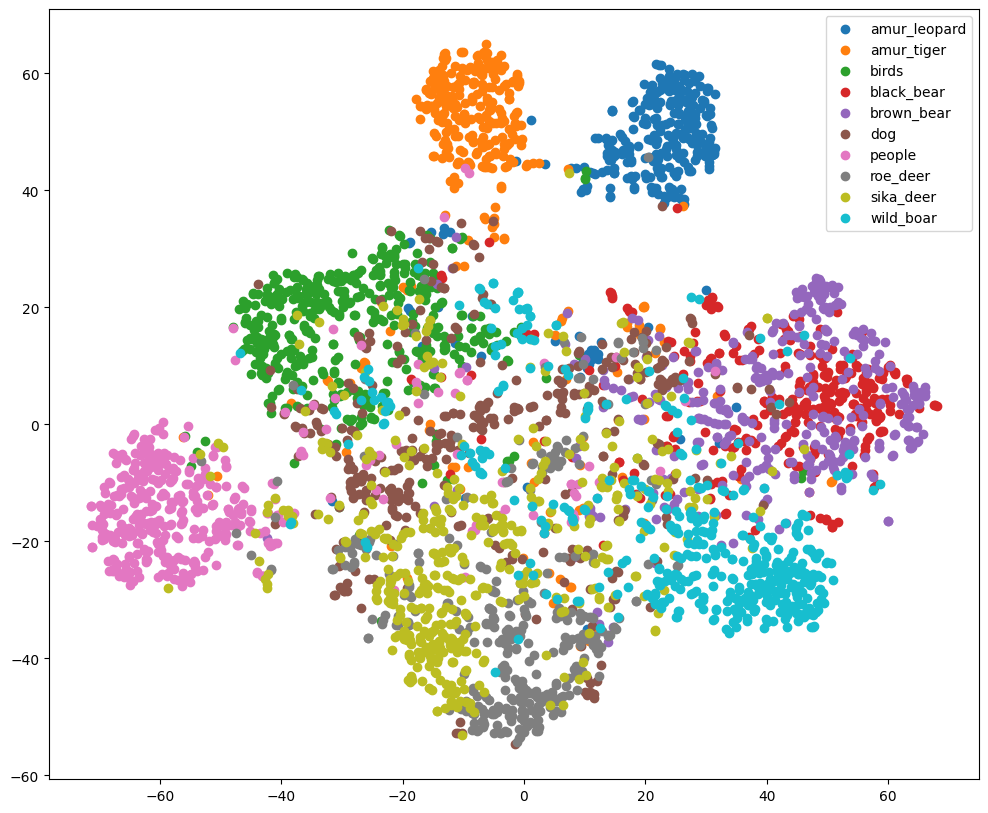

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))

tsne = TSNE(n_components=2, random_state=0)  
X_tsne = tsne.fit_transform(embeds)

groups = pd.DataFrame(X_tsne, columns=['x', 'y']).assign(category=y).groupby('category')
for name, points in groups:
    ax.scatter(points.x, points.y, label=name)

ax.legend()

plt.show()

In [8]:
tsne = TSNE(n_components=3, random_state=0)  
X_tsne = tsne.fit_transform(embeds)

fig = px.scatter_3d(
    X_tsne, x=0, y=1, z=2,
    color=y,
    title='3D t-SNE Visualization'
)

fig.update_traces(marker=dict(size=5), showlegend=True)
fig.update_layout(
    width=1000,
    height=800
)

fig.show()